In [1]:
from typing import Any, List, Dict, Optional
from dataclasses import dataclass, field
from pathlib import Path
import os.path as op

from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from pysankey2 import Sankey
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from cluster import reindex_clusters

In [2]:
# Join similarity matrices - should only need to run once
def join_similarities():
    sim_paths = Path('../data/similarity/')

    df_similarity = None
    for f in sim_paths.rglob('*h5'):
        dataset, atlas = str(f).split('/')[-1].split('_')[0:2]
        tdf = pd.read_hdf(f)
        tdf['dataset'], tdf['atlas'] = dataset, atlas

        if df_similarity is None:
            df_similarity = tdf
        else:
            df_similarity = pd.concat([df_similarity, tdf])

    pd.to_pickle(df_similarity, '../data/clustering/preprocessed_similarity.pkl')

In [3]:
@dataclass
class ClusteringFrames:
    definitions: Optional[pd.DataFrame] = None
    data: Optional[pd.DataFrame] = None
    subjects: Optional[pd.DataFrame] = None
    overlap: Optional[pd.DataFrame] = None
    plot: Optional[Any] = None
    combinations: List = field(default_factory=list)
    sorting: Dict = field(default_factory=lambda: {})
    plot_order: List = field(default_factory=lambda: ['aal', 'cc2', 'hox', 'des'])


# Utility function to slice dataframes
def get_df_slice(df, ds, at):
    return df[(df['dataset'] == ds) & (df['atlas'] == at)]


# Utility function to get and stack cluster signatures
def get_signatures(df, c):
    return np.stack([np.reshape(_, -1) for _ in get_df_slice(df, *c)['signature']])


def compare_clustering(cluster_definitions: pd.DataFrame, cluster_data: pd.DataFrame,
                       subject_similarity: pd.DataFrame, dataset: str, across: str="atlas",
                       plot: bool=True):
    if across != "atlas":
        raise NotImplementedError("Only across atlas comparisons are currently supported.")

    # Create data class for clustering informations
    cf = ClusteringFrames()

    # Reduce dataframe to only contain dataset of interest
    cf.definitions = cluster_definitions[cluster_definitions['dataset'] == dataset]
    cf.data = cluster_data[cluster_data['dataset'] == dataset]
    cf.subjects = subject_similarity[subject_similarity['dataset'] == dataset]
    
    # Set up some convenience variables and lambdas
    da = ['dataset', 'atlas']  # Regularly used for subsampling dataframe
    cois = ['subject', 'session', 'dataset', 'atlas']  # Used to subsample subject dataframe
    cf.combinations = cf.definitions.value_counts(da).index  # Is sorted in order of most->fewest clusters 

    # Extract info from reference parcellation (the one with the most clusters)
    dataset_atlas = cf.combinations[0]
    sig_ref = get_signatures(cf.definitions, dataset_atlas)
    cf.sorting[dataset_atlas[1]] = np.arange(len(sig_ref)) # dataset_atlas[1] is the atlas name

    # Set up subject matrix for cluster assignment, and populate with reference
    cf.subjects = cf.subjects[cois].groupby(['subject', 'session']).max()
    labels = get_df_slice(cf.data, *dataset_atlas)['labels'].values[0]
    cf.subjects[dataset_atlas[1]] = reindex_clusters(labels, order=cf.sorting[dataset_atlas[1]])

    # Match clusters from other parcellations
    for idx, da2 in enumerate(cf.combinations[1:]):
        # da2 = dataset_atlas_2
        sig_targ = get_signatures(cf.definitions, da2)

        # Compute similarity of clusters, and match them
        cost = cdist(sig_ref, sig_targ, metric='cosine')
        reorder = linear_sum_assignment(cost)
        cf.sorting[da2[1]] = np.argsort(reorder[1])

        # Assign cluster memberships (with updated indice) back to subjects/sessions
        labels = get_df_slice(cf.data, *da2)['labels'].values[0]
        cf.subjects[da2[1]] = reindex_clusters(labels, order=cf.sorting[da2[1]])

    # Create utility dataframes and perform Sankey plotting
    if plot:
        # Set colourmap for plot
        cm = ["#9d973f", "#b253c0", "#64ac48", "#6768cc", "#c67f40", "#5d94ce",
              "#d04a3e", "#4aac8b", "#d14788", "#bb7fc1", "#bb6271"]
        # From : http://medialab.github.io/iwanthue/
        
        # Rename columns and establish the (sequential) sorting of clusters
        col_names = {atlas: 'layer'+str(_+1)
                     for _, atlas in enumerate(cf.plot_order)}
        cords = {'layer'+str(_+1): np.arange(len(cf.sorting[atlas]))
                 for _, atlas in enumerate(cf.plot_order)}
        
        # Create a slimmed down dataframe for Sankey
        sankey_df = cf.subjects[cf.plot_order]
        sankey_df = sankey_df.rename(columns=col_names)
        sankey_df = sankey_df.reset_index().drop(columns=['subject', 'session'])

        color_dict = {_: cm[_] for _ in range(len(sig_ref))}
        
        # Plot
        cf.plot = Sankey(sankey_df, colorMode='global', stripColor='gray', colorDict=color_dict, layerLabels=cords)
        fig, ax = cf.plot.plot(figSize=(15, 15), fontSize=0)
        plt.title(dataset_atlas[0])
        fig.show()

    return cf

In [4]:
df_cluster_def = pd.read_pickle('../data/clustering/cluster_definitions.pkl')
df_cluster_dat = pd.read_pickle('../data/clustering/cluster_membership.pkl')
if not op.exists('../data/clustering/preprocessed_similarity.pkl'):
    join_similarities()
df_similarity = pd.read_pickle('../data/clustering/preprocessed_similarity.pkl')

datasets = sorted(df_cluster_def['dataset'].unique())
def cc_easy(dataset, **kwargs):
    return compare_clustering(df_cluster_def, df_cluster_dat, df_similarity, dataset, **kwargs)

/jet/home/gkiar/env/gp38/lib/python3.8/site-packages/pysankey2/pysankey2.py:450: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = figSize)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


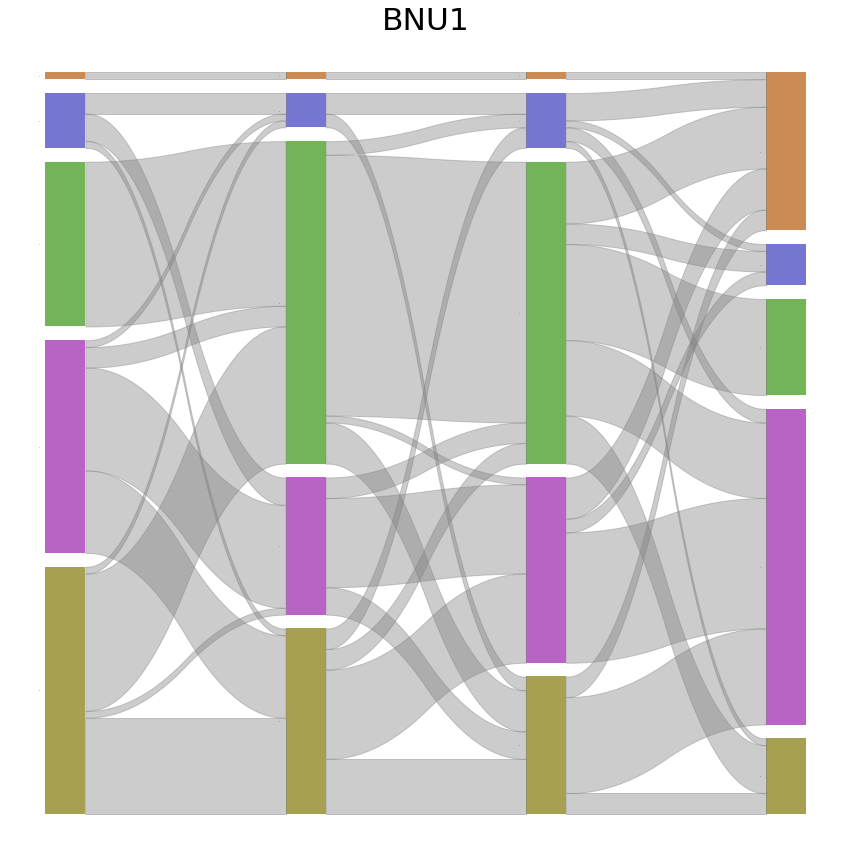

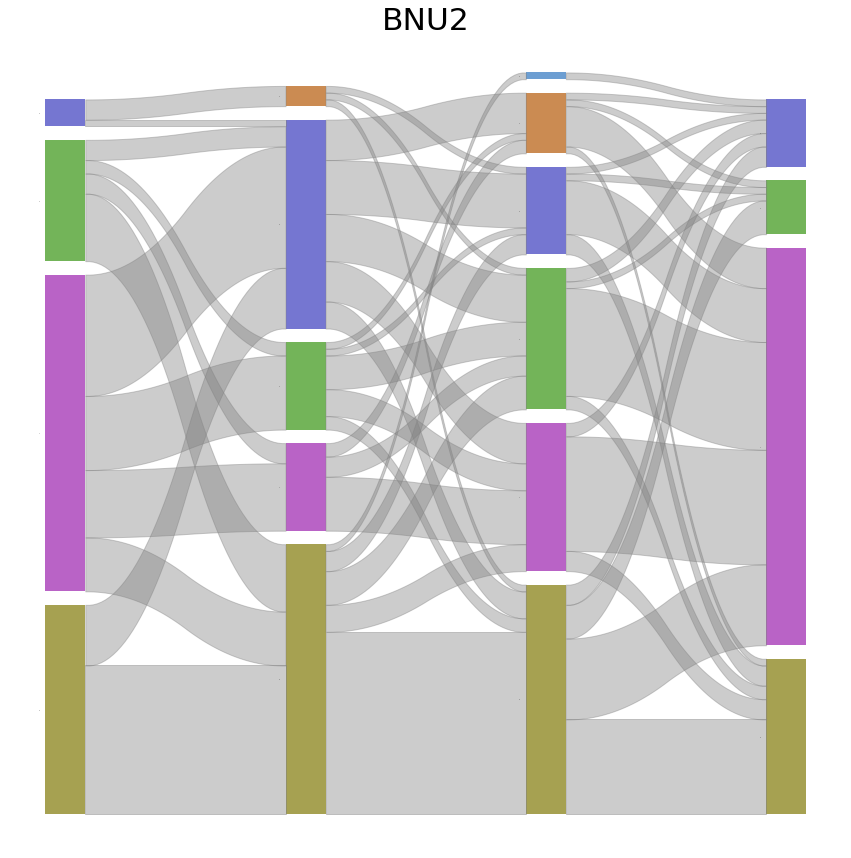

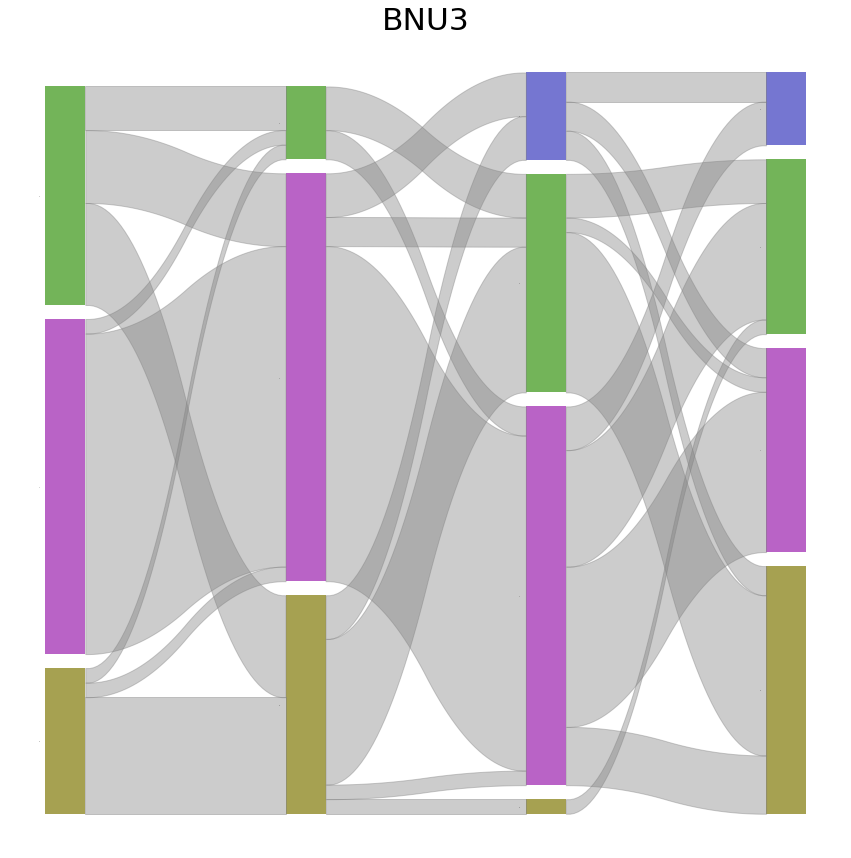

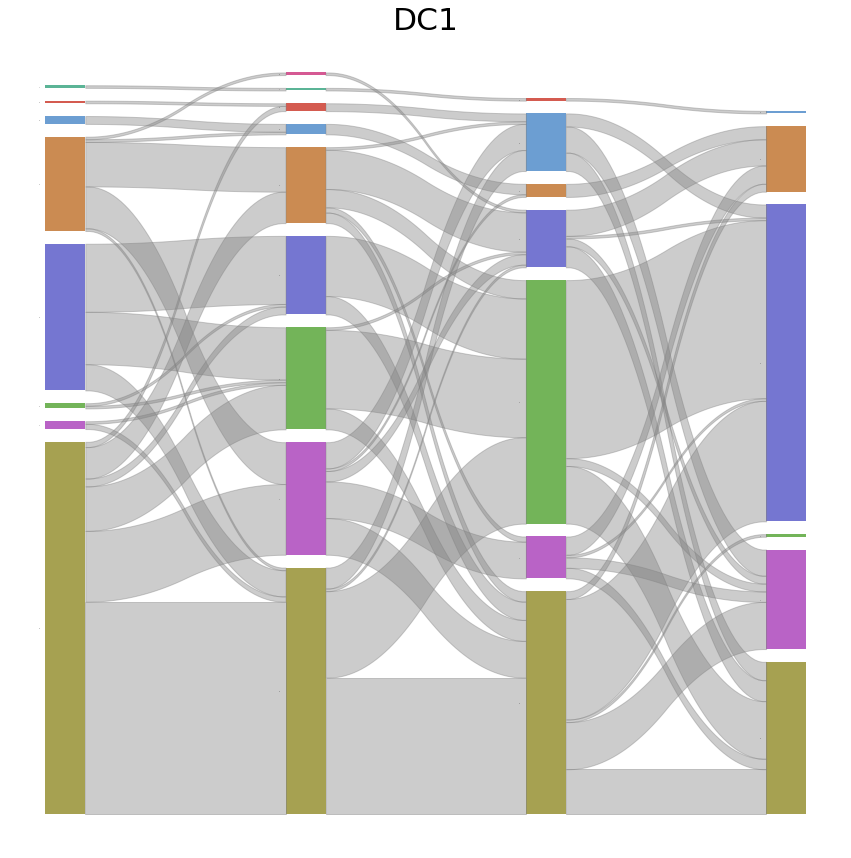

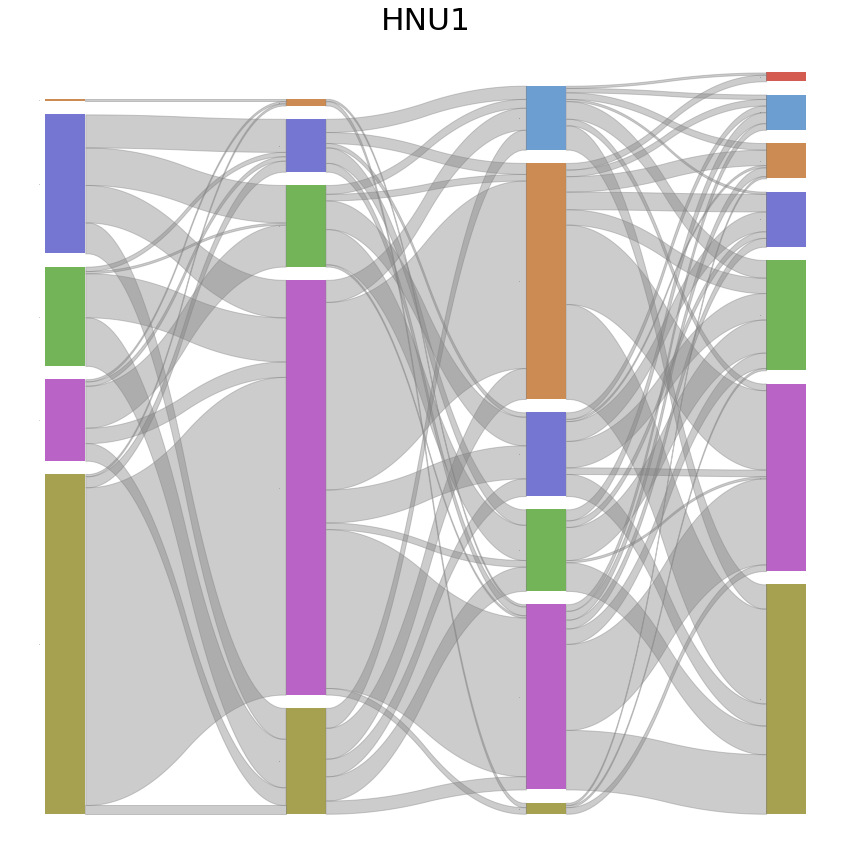

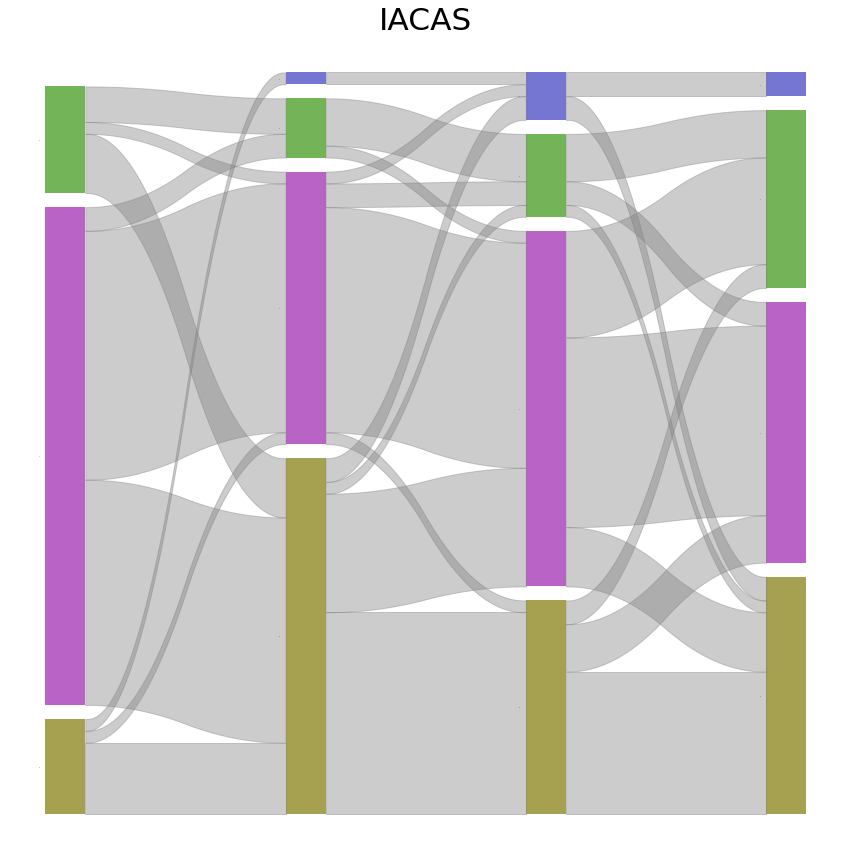

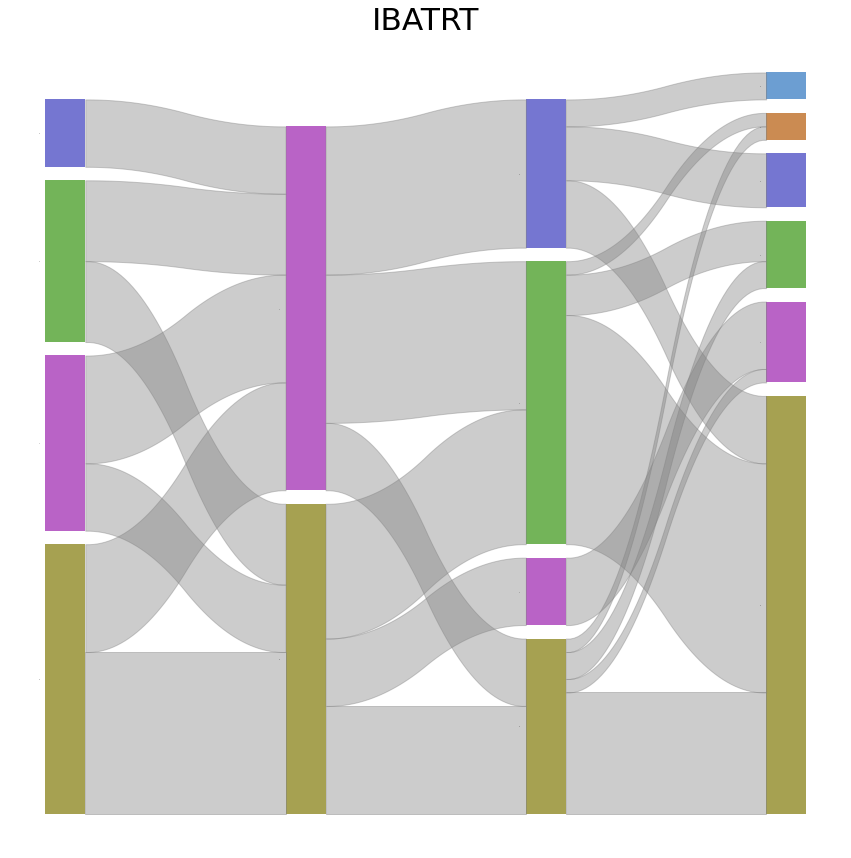

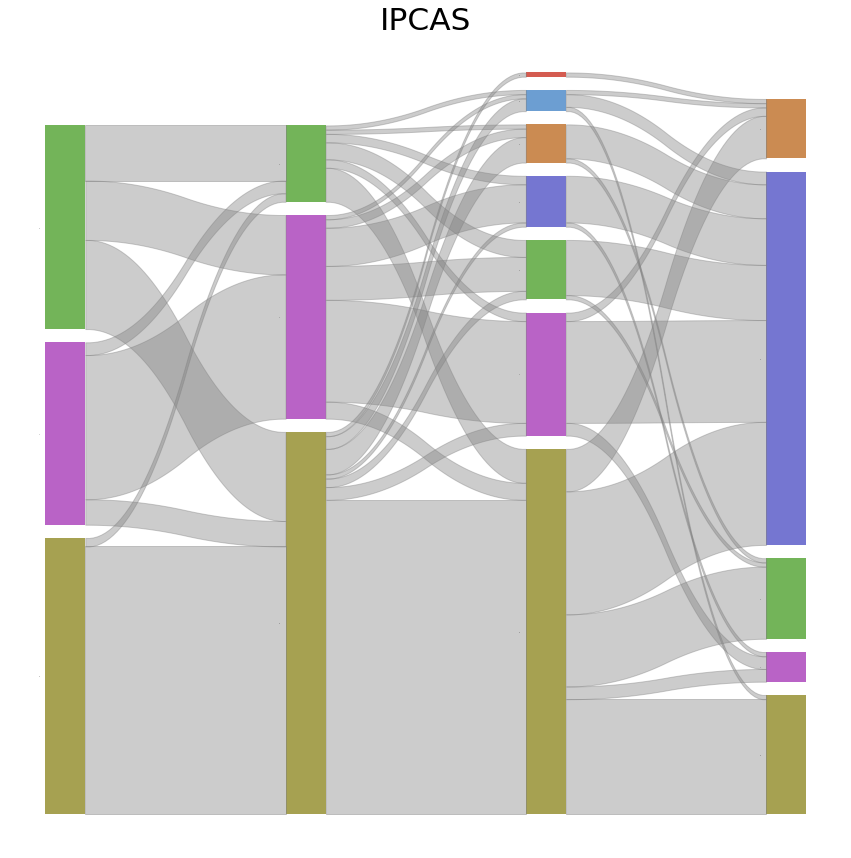

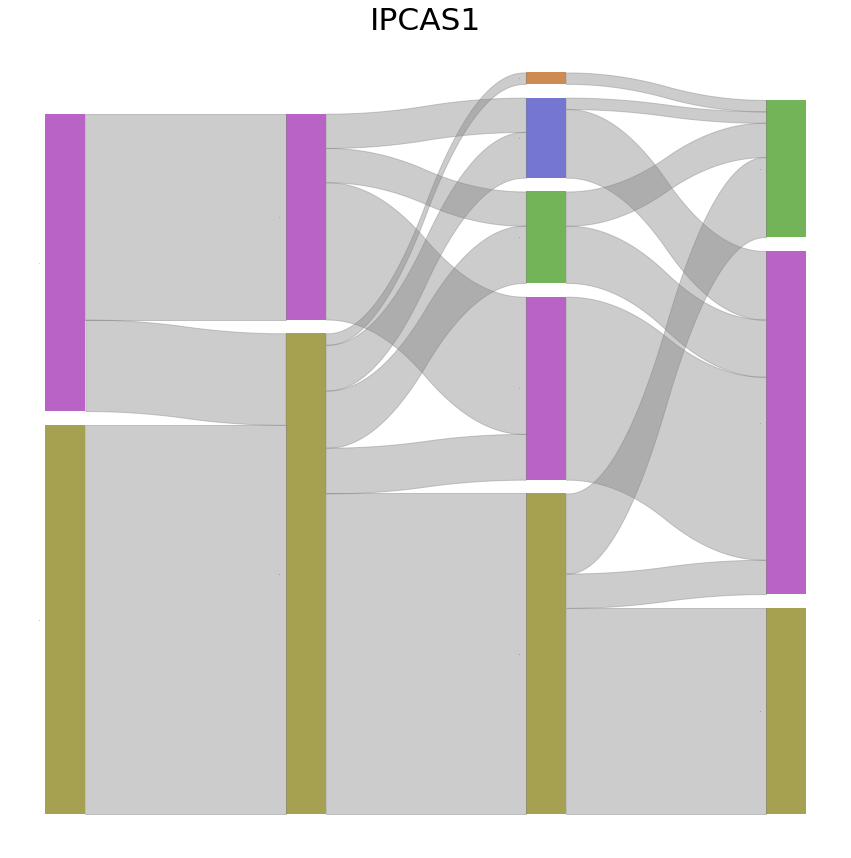

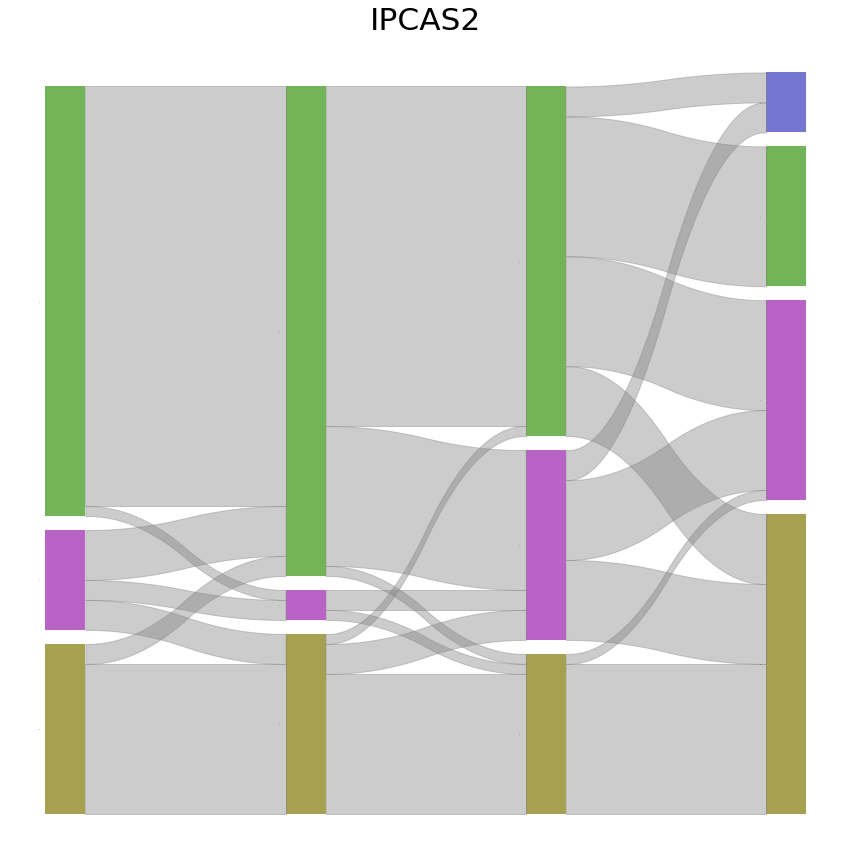

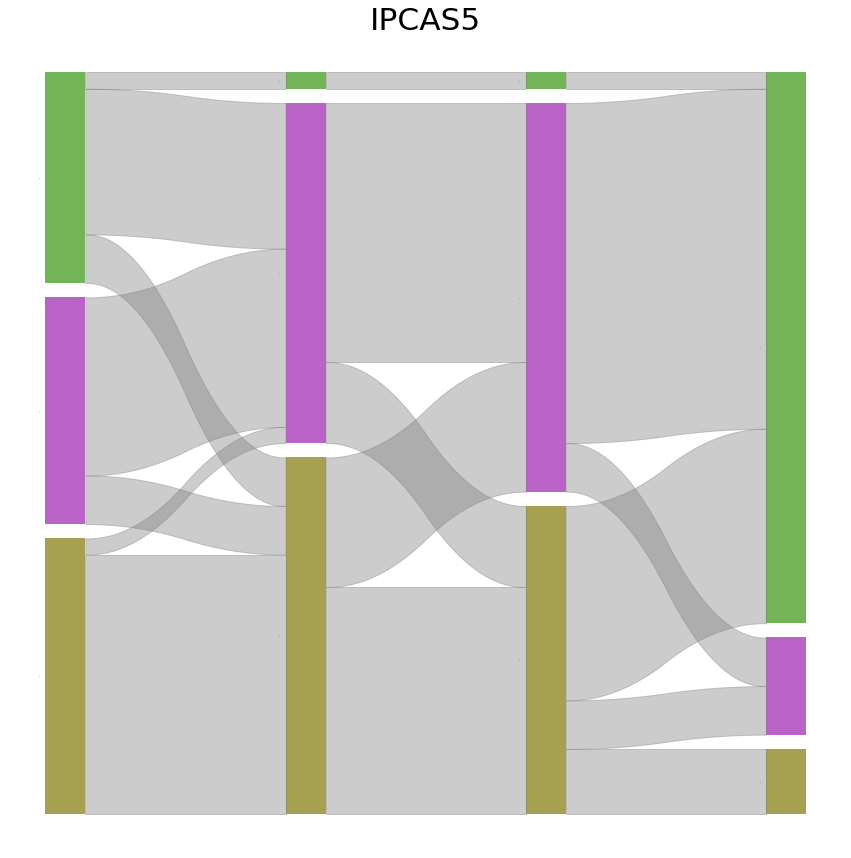

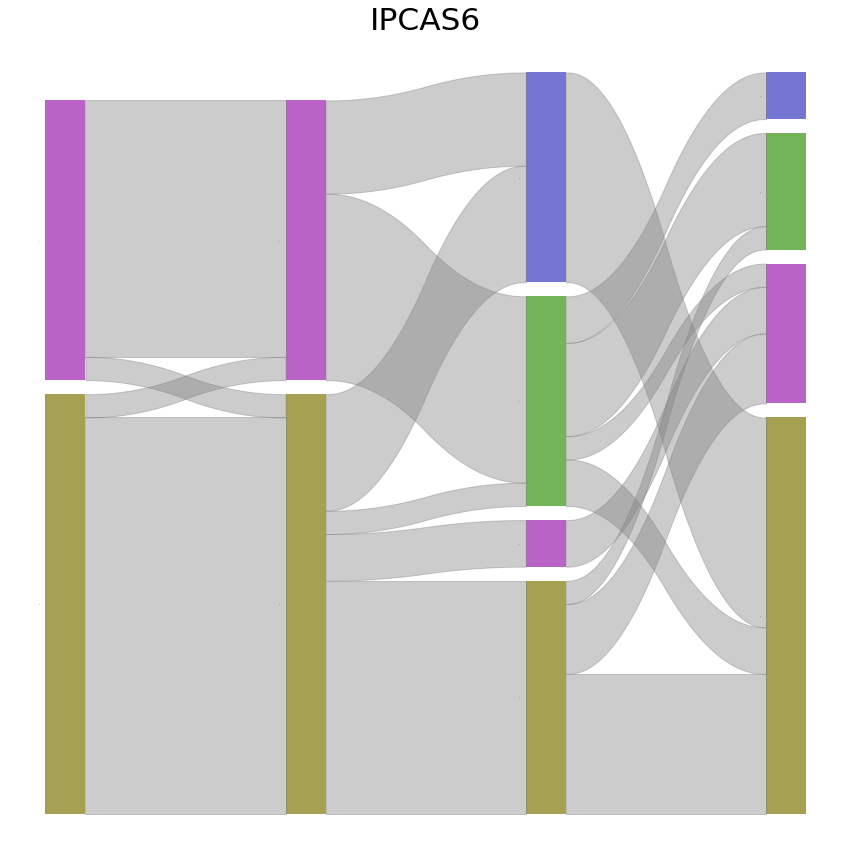

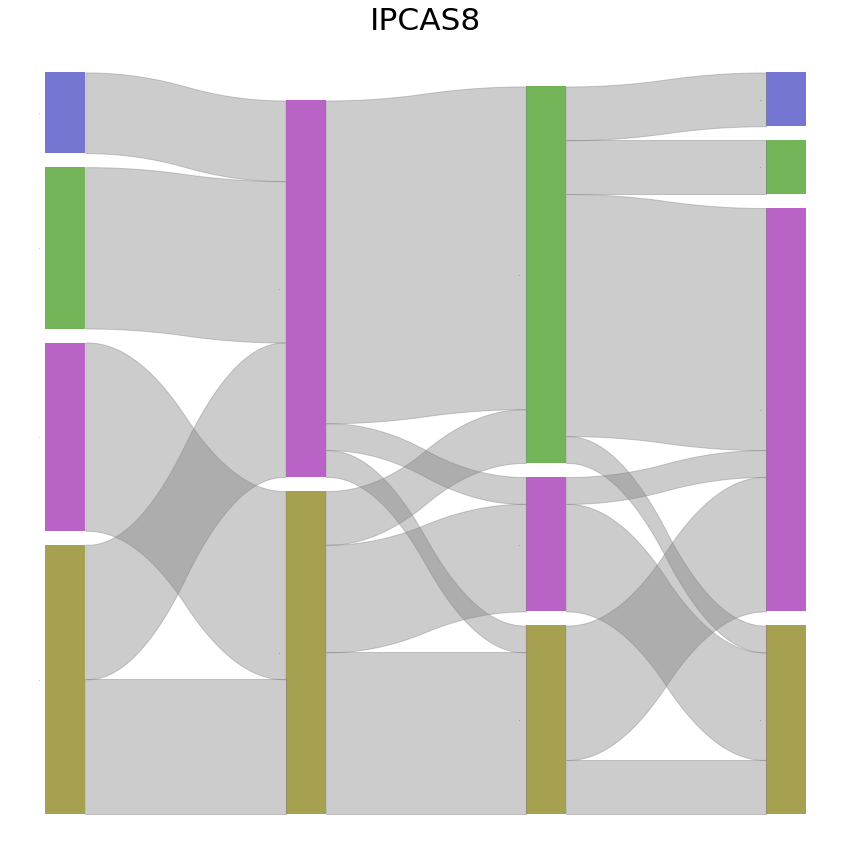

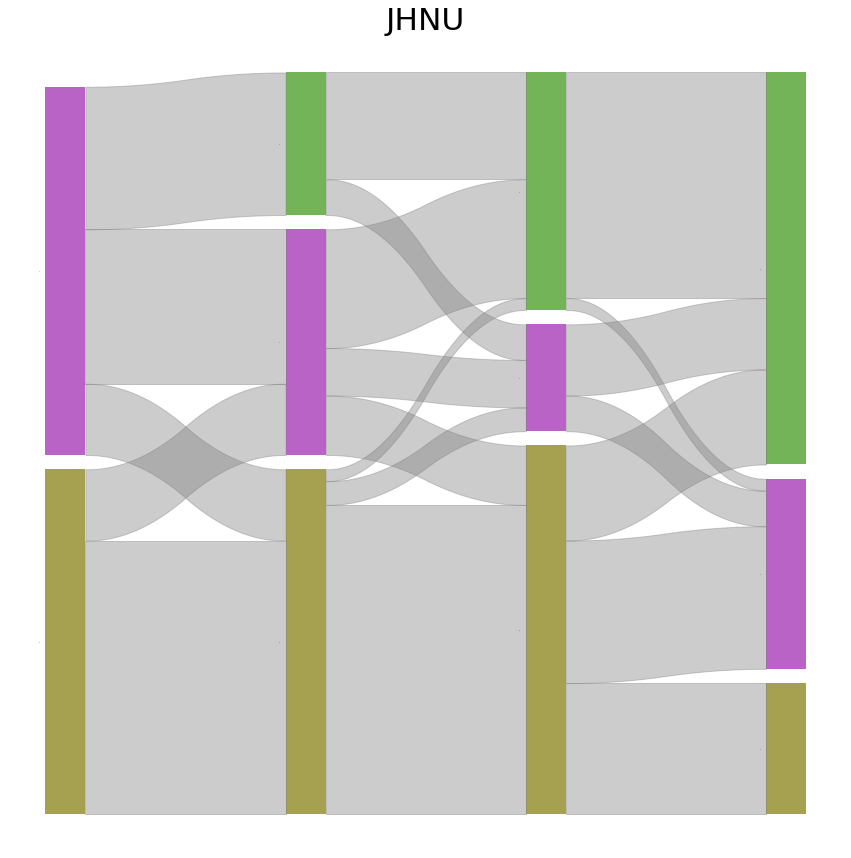

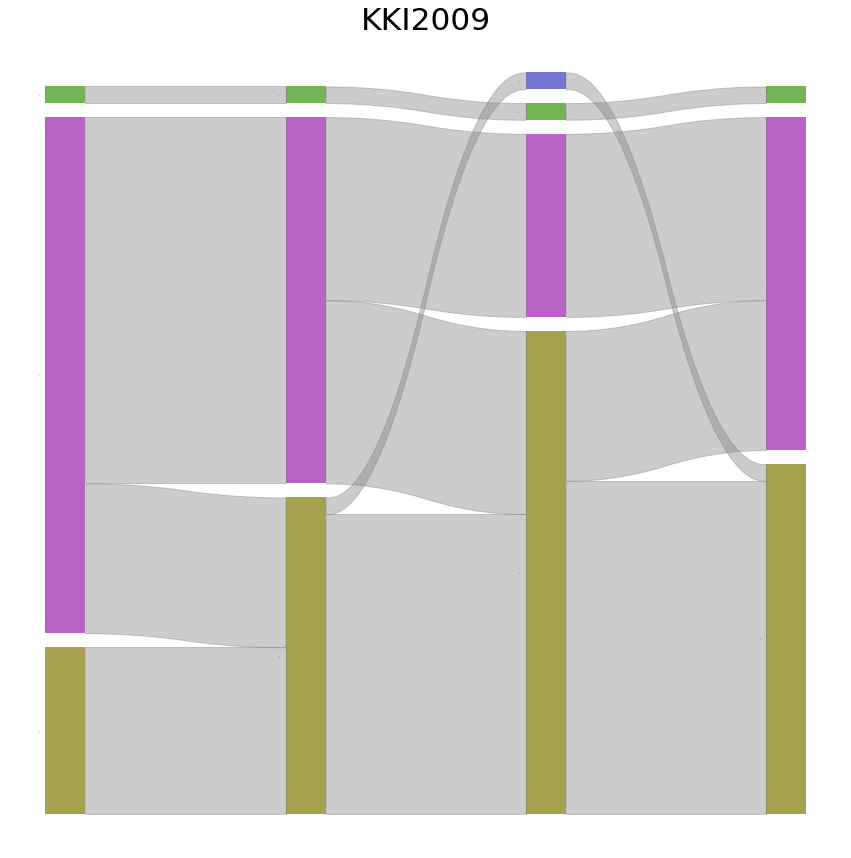

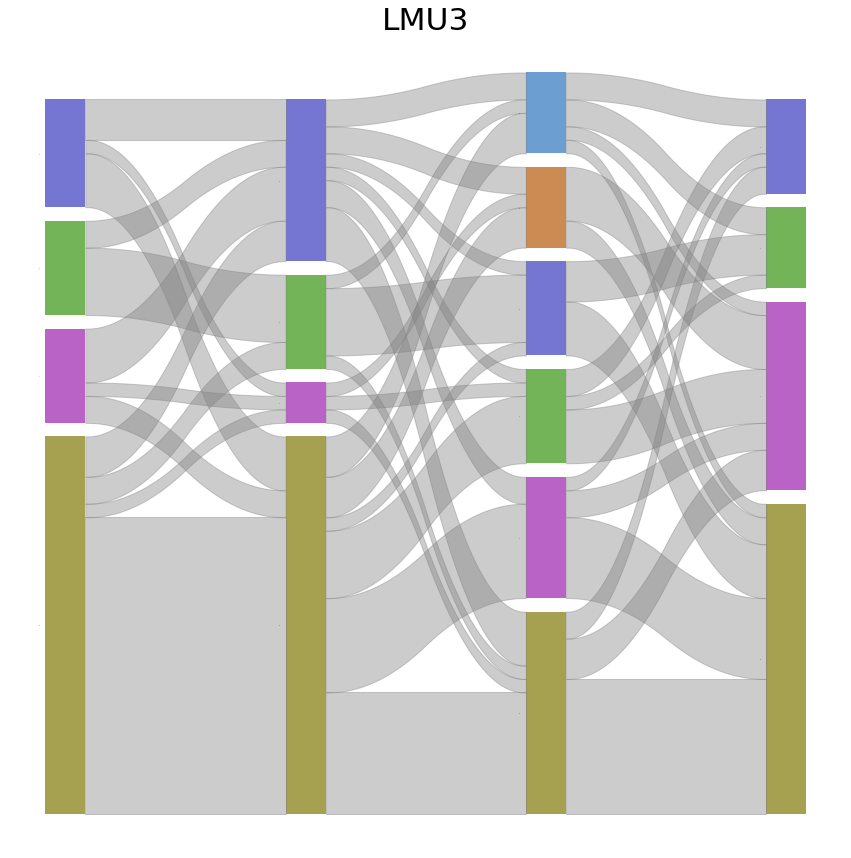

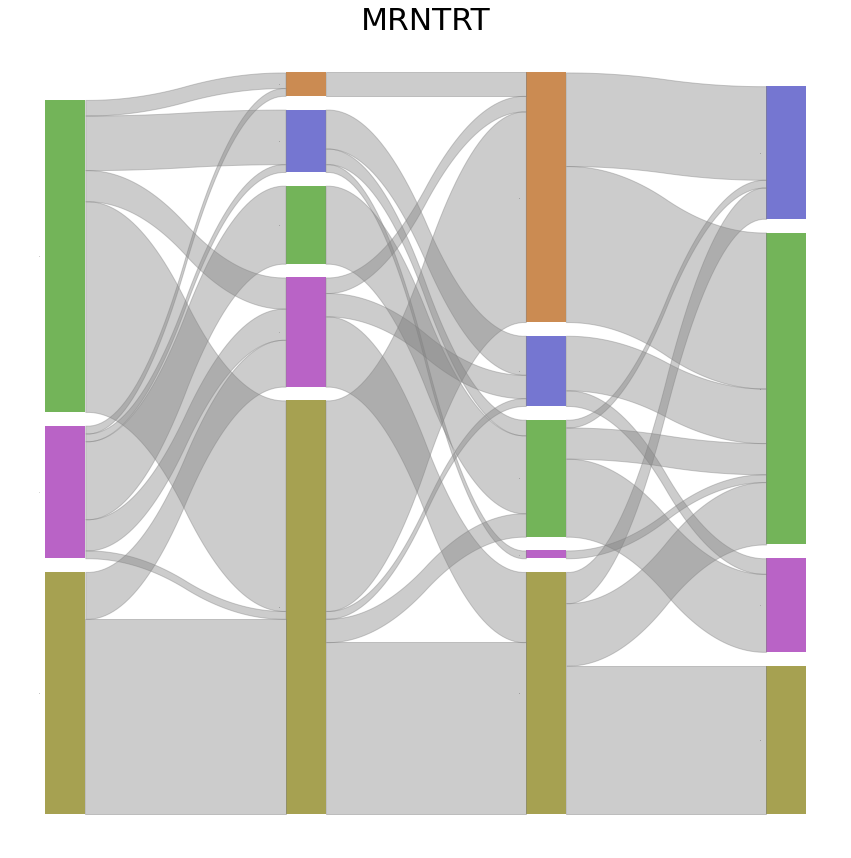

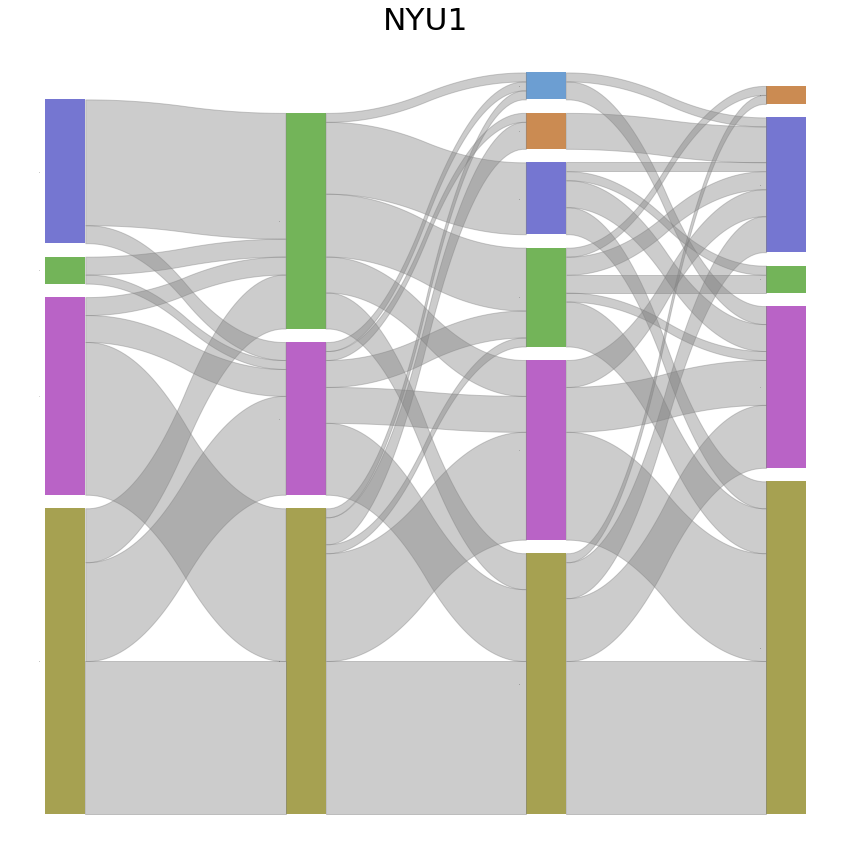

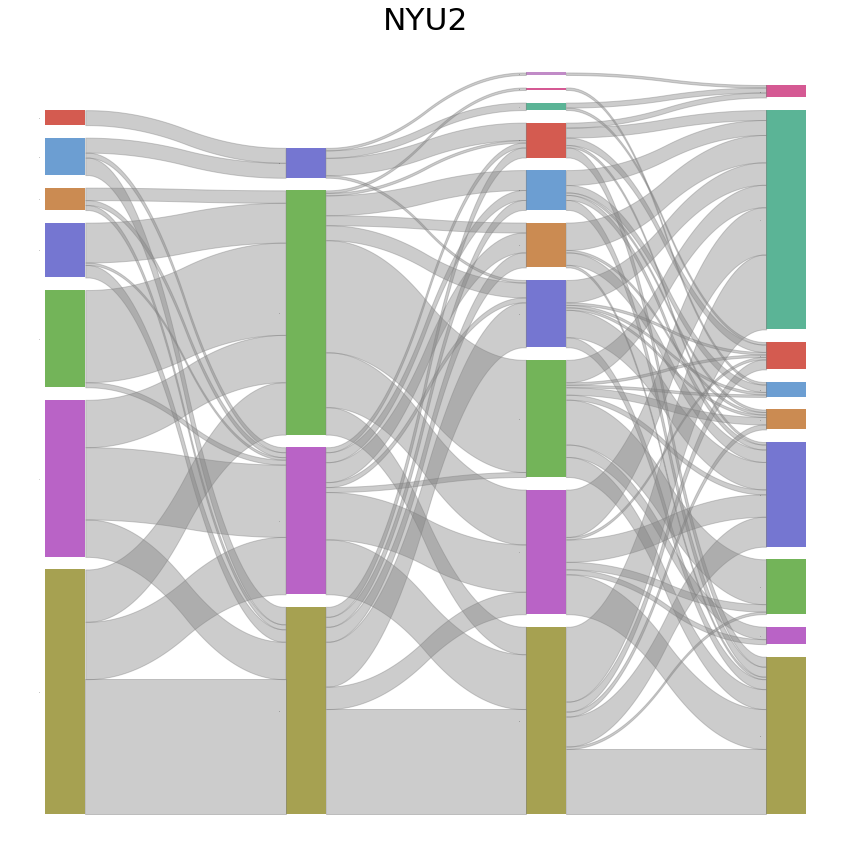

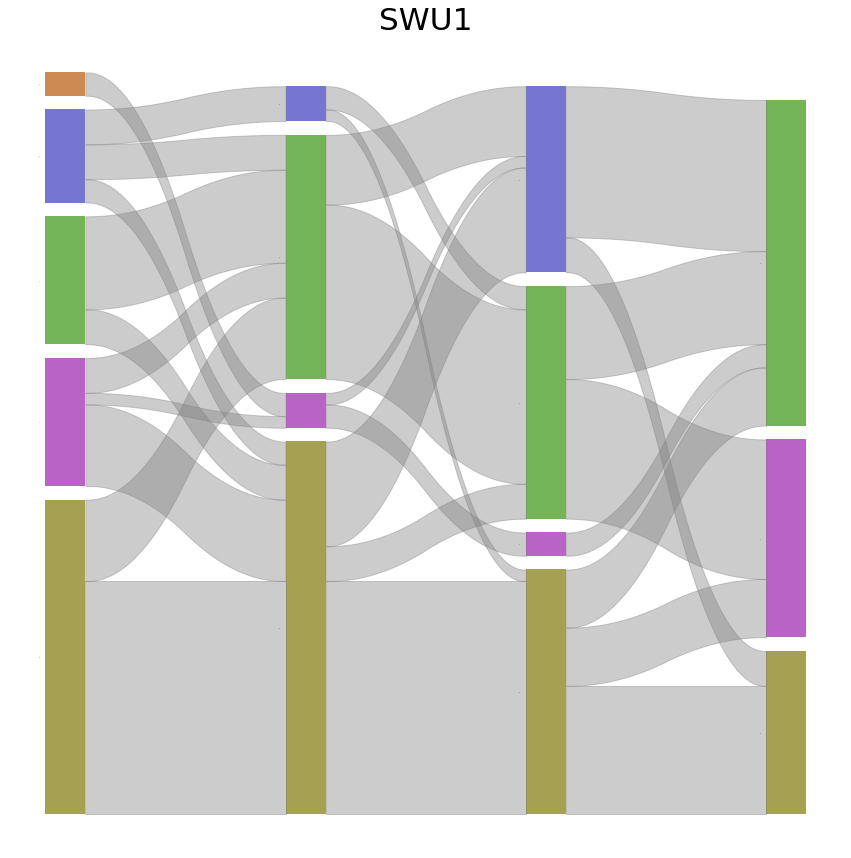

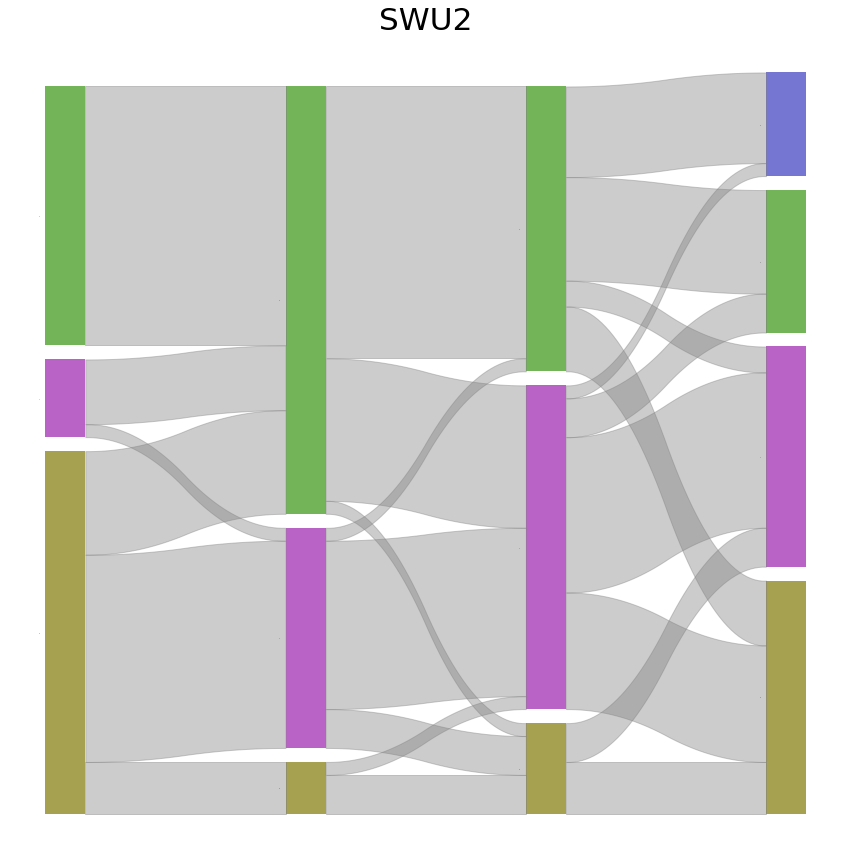

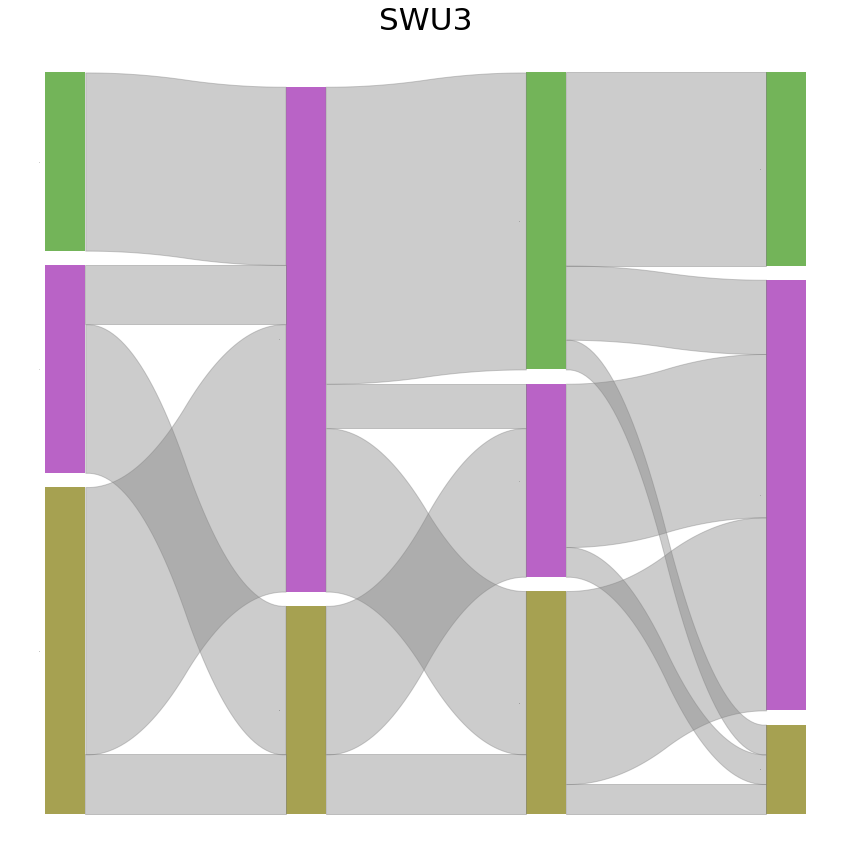

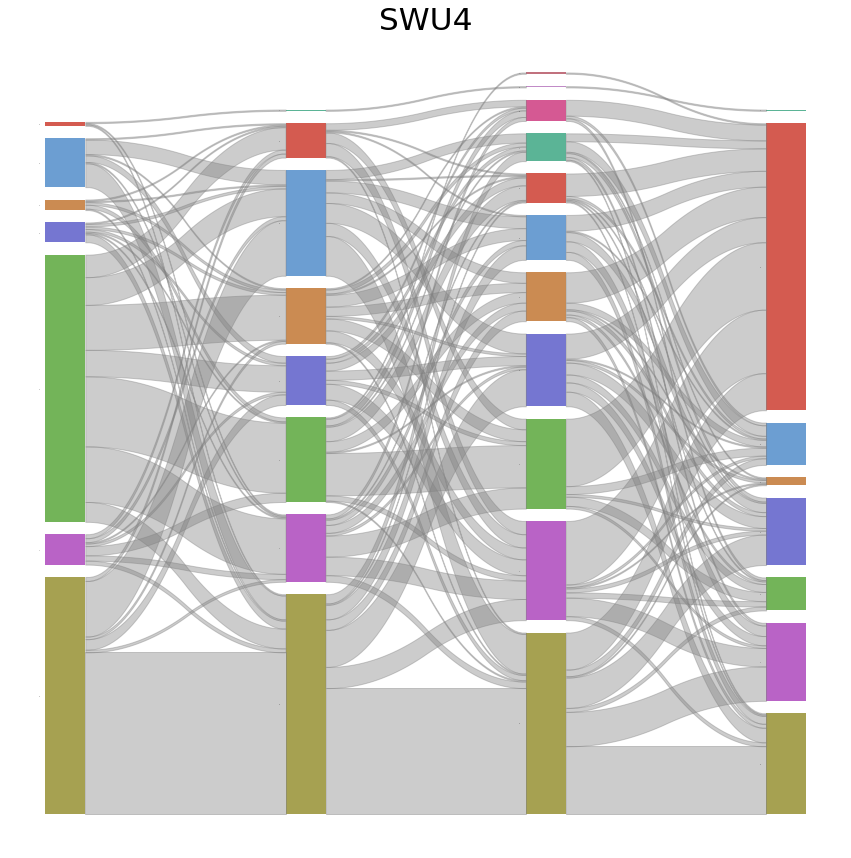

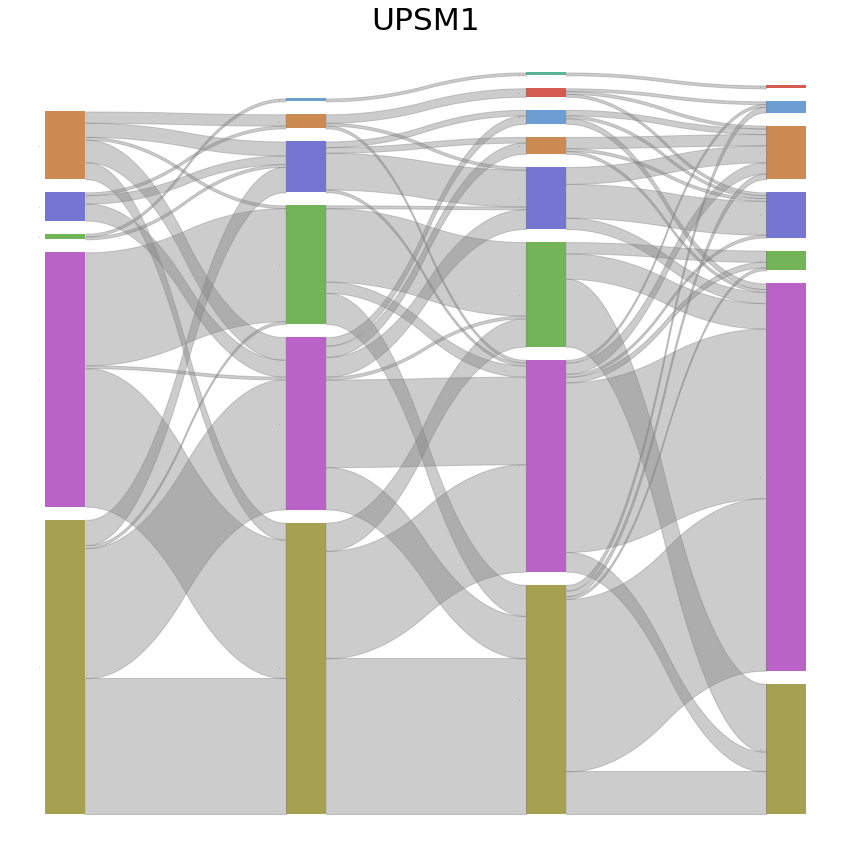

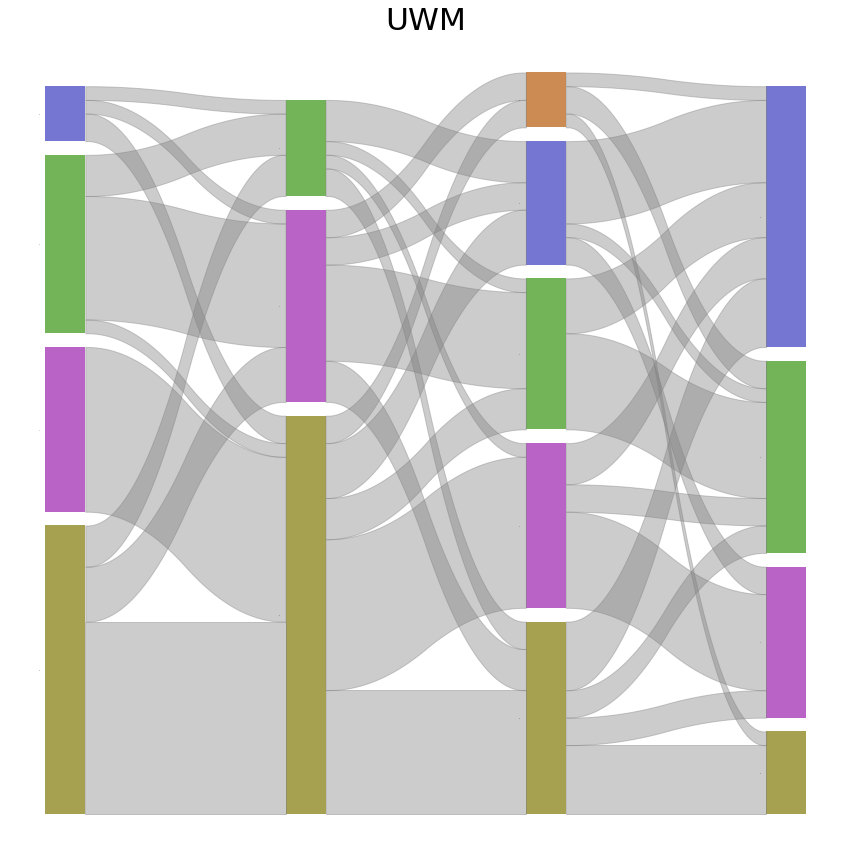

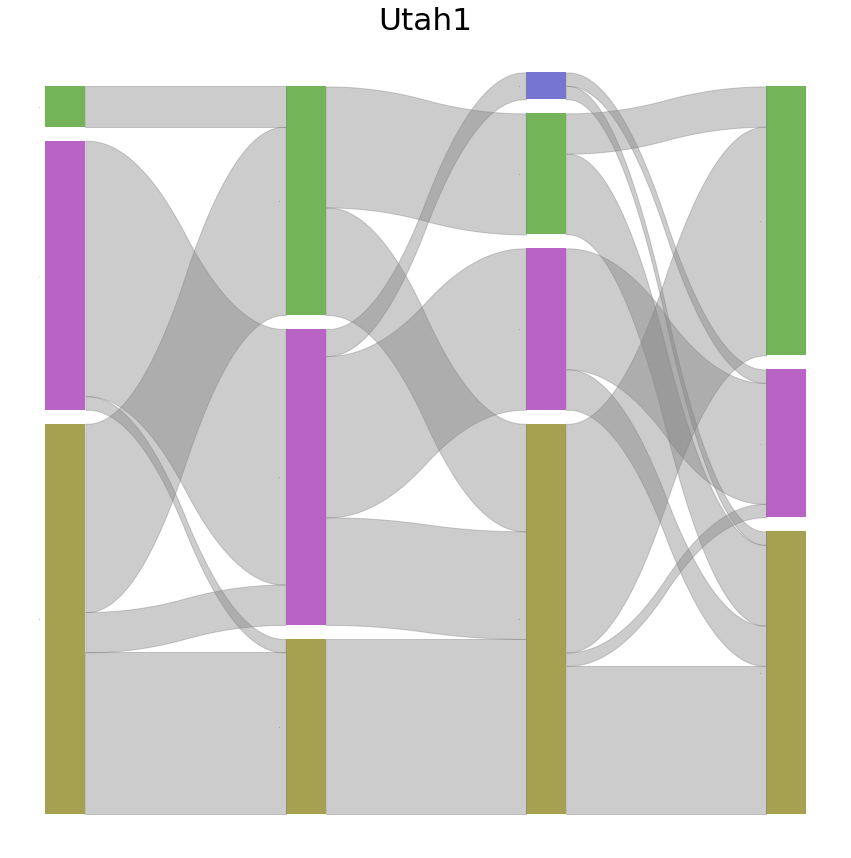

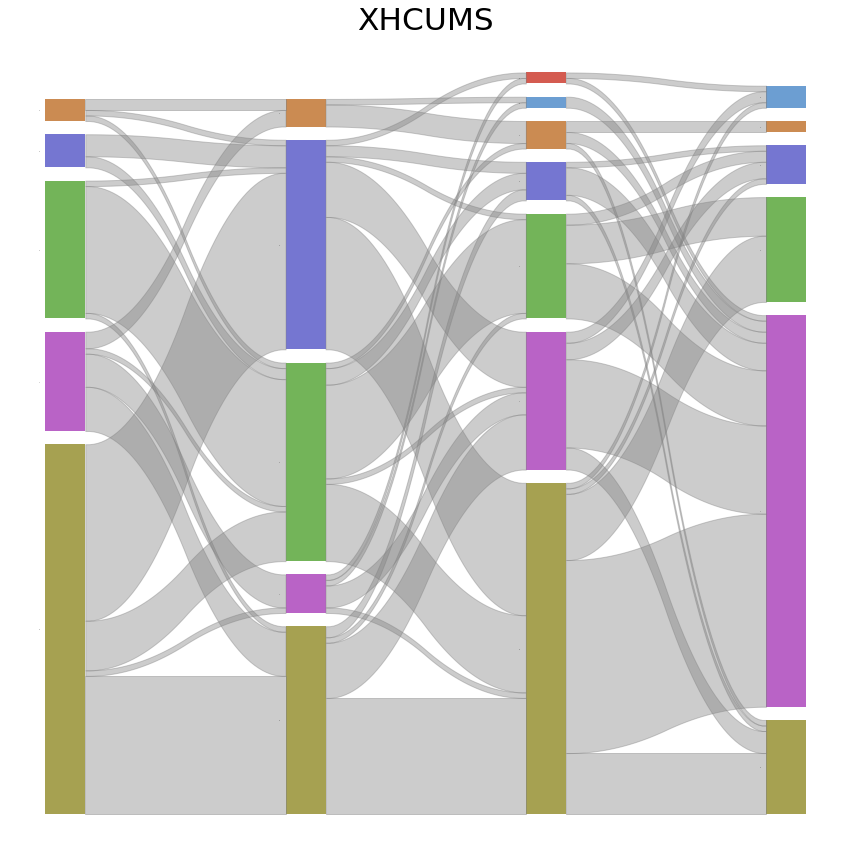

In [5]:
cf = {}
for d in datasets:
    cf[d] = cc_easy(d, plot=True)

In [6]:
tdf_s = []
tdf_a = []

# Perform some post-processing for the datasets all together
for d in datasets:
    # Extract the relevant clustering (data)frames collection
    tcf = cf[d]
    
    # Compute the variation in cluster membership across sessions
    is_trt = len(tcf.subjects.index.unique(level='subject')) < len(tcf.subjects.index)
    if is_trt:
        session_variation = tcf.subjects.groupby('subject').var(numeric_only=True).apply(lambda x: x > 0)
        session_variation.sum(axis=0)/len(session_variation)
        
    
    # Compute the variation in cluster membership across atlases
    for idx, da1 in enumerate(tcf.combinations):
        for jdx, da2 in enumerate(tcf.combinations[idx+1:]):
            l1 = get_df_slice(tcf.data, *da1).labels.values[0]
            l2 = get_df_slice(tcf.data, *da2).labels.values[0]
            tmp = l1 == l2

            tdf_a += [{
                "dataset": da1[0],
                "atlas1": da1[1],
                "atlas2": da2[1],
                "ARI": adjusted_rand_score(l1, l2),
                "AMI": adjusted_mutual_info_score(l1, l2),
                "Percent Overlap": np.sum(tmp)/len(tmp)*100
            }]

overlap = pd.DataFrame.from_dict(tdf_a)
overlap

,dataset,atlas1,atlas2,ARI,AMI,Percent Overlap
0,BNU1,aal,cc2,0.264409,0.353958,36.000000
1,BNU1,aal,des,0.083269,0.114729,33.000000
2,BNU1,aal,hox,0.138820,0.167876,35.000000
3,BNU1,cc2,des,0.045418,0.159529,20.000000
4,BNU1,cc2,hox,0.393394,0.312380,59.000000
...,...,...,...,...,...,...
157,XHCUMS,hox,aal,0.216000,0.218774,39.166667
158,XHCUMS,hox,cc2,0.139202,0.229154,25.000000
159,XHCUMS,des,aal,0.177028,0.230831,52.500000
160,XHCUMS,des,cc2,0.050059,0.124361,38.333333


In [7]:
overlap.describe()

,ARI,AMI,Percent Overlap
count,162.000000,162.000000,162.000000
mean,0.190582,0.232728,36.706510
std,0.133218,0.110417,18.385048
min,-0.070962,0.032306,5.769231
25%,0.095844,0.152377,21.750000
50%,0.176414,0.224182,33.949153
75%,0.253249,0.300838,49.215909
max,0.742516,0.628475,93.333333


In [ ]:
def label_entropy():
    # Count the number of labels
    # Do a value count for how often each appears for a given subject
    # Compute entropy on the count
    # Average entropy over all subjects
    pass

In [33]:

tcf.subjects.groupby('subject').agg()

In [30]:
tcf.subjects.groupby('subject').value_counts(subset=['hox'])

subject  hox
0025982  1      3
         0      2
0025983  0      4
         1      1
0025984  1      3
               ..
0026005  3      1
         2      1
0026006  1      2
         0      2
         3      1
Name: count, Length: 61, dtype: int64

In [ ]:
tcf.subjects.groupby('subject').value_counts

In [19]:
tcf.subjects.groupby('subject').value_counts()

subject  dataset  atlas  aal  cc2  des  hox
0025864  BNU1     hox    1    0    4    1      1
                         2    2    0    2      1
0025865  BNU1     hox    2    2    2    2      1
                         0    2    2    2      1
0025866  BNU1     hox    2    2    4    2      1
                                              ..
0025911  BNU1     hox    0    0    1    1      1
0025912  BNU1     hox    1    1    1    0      1
                         0    2    0    0      1
0025913  BNU1     hox    1    1    0    0      1
                         4    4    4    4      1
Name: count, Length: 99, dtype: int64

In [17]:
session_variation = tcf.subjects.groupby('subject').var().apply(lambda x: x > 0)
df = session_variation.sum(axis=0)/len(session_variation)


hox    1.000000
des    0.833333
aal    0.875000
cc2    0.958333
dtype: float64

In [18]:
tcf.subjects

dataset atlas  hox  des  aal  cc2
subject session                                  
0025982 1        XHCUMS   hox    0    0    0    0
        2        XHCUMS   hox    0    1    2    0
        3        XHCUMS   hox    1    3    1    1
        4        XHCUMS   hox    1    0    0    0
        5        XHCUMS   hox    1    1    0    3
...                 ...   ...  ...  ...  ...  ...
0026006 1        XHCUMS   hox    3    1    3    3
        2        XHCUMS   hox    1    1    3    2
        3        XHCUMS   hox    0    1    0    0
        4        XHCUMS   hox    1    1    0    3
        5        XHCUMS   hox    0    1    0    0

[120 rows x 6 columns]